The goal of this notebook is an exploration, and implementation, of the Kropff and Treves 2008 model for grid cells. Below is a rough flowchart of the models' processes.

![FLOWCHART](KrTr2008.png)

Before we can get to the model, we have to simulate some basic data for testing, using a random walk. Specifically, it will be similar to the one described in the paper, in that it randomly bounces off of the arena walls. The simulation will output coordinate data (x and y), but can also be used to calculate velocity if desired

In [3]:
import numpy as np
import matplotlib.pyplot as plt

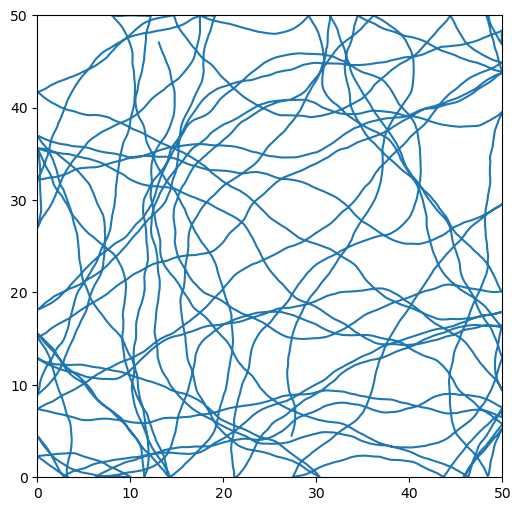

In [44]:
#Sim Parameters
aSize = 50
steps = 20000
speed = 0.1

#Calculates vector using angle
def conv(ang):
        x = np.cos(np.radians(ang)) 
        y = np.sin(np.radians(ang)) 
        return x , y

def random_walk(aSize, steps, speed):

    #Plotting setup
    fig, ax = plt.subplots()
    fig.set_size_inches((6,6))
    ax.set_xlim(xmin = 0, xmax=aSize)
    ax.set_ylim(ymin = 0, ymax=aSize)


    

    #random initial val
    x = [np.random.uniform(0, aSize)]
    y = [np.random.uniform(0, aSize)]
    theta = np.random.uniform(0, 360)

    for step in range(steps-1):

        theta += np.random.uniform(-5,5)

        while (x[-1] + speed*conv(theta)[0] > aSize) or (x[-1] + speed*conv(theta)[0] < 0):
            theta = np.random.uniform(0,360)

        while (y[-1] + speed*conv(theta)[1] > aSize) or (y[-1] + speed*conv(theta)[1] < 0):
            theta = np.random.uniform(0,360)

        x.append(x[-1] + speed*conv(theta)[0])
        y.append(y[-1] + speed*conv(theta)[1])

        
    ax.plot(x,y,'-')

    plt.show()

    return np.asarray((x, y))

coords = random_walk(aSize, steps, speed)

Done! Now let's setup the initial parameters

In [2]:
#default paramters from paper
N_mEC = 100
N1 = 200
b1 = 0.1
b2 = b1/3
sat = 30 #Psi_Saturation
a0 = 0.1 * sat
s0 = 0.3
eps = 0.001 #epsilon

First up is the pre-synaptic neural layer. These neurons are not actually a part of the grid cells (Those are the post-synaptic neurons), but rather the input. For now, they will be place cells much as in the paper. Later on, once we know the model is working, we can try different inputs. 

To keep things simple, these place cells will have circular receptive fields, initialized randomly across the arena. The firing rate will be between 0 and 1, with firing rate inversely proportional to the distance from center of the receptive fields.

In [ ]:
class placeCell():
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def calc_activity(self, coord):
        distance = self.center = coord
        return

In [ ]:
point = np.asarray([2,2])
r = 5
